In [1]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *
from math import log10, floor
import cftime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# simulation parameters
rot = False
small_earth_fact = 60 
center_lon = 120
R_earth = 6.371220E6

In [3]:
# Information about the paths
model = 'SE' # 'SE' or 'FV3' or 'MPAS'
res = 'ne30'  # 'ne30' or 'C96' or '120' for 1-deg and 'ne60' or 'C192' or '60' for 0.5 deg
vert = 'nonhydrostatic'

# Edit this to your own case name
case = f'dcmip25_squall_{model.lower()}_{res}'

# Modify the following according to your naming convention
nc_file = case + '.cam.h0i.0001-01-01-00000.nc'

# Define the base root to the data,
# add your username
username = 'nandrosk'
run_base = f'/glade/work/{username}/dcmip25/'
output_base = f'/glade/u/home/{username}/'

# Automatically set some paths
#run_path = run_base + case + '/run/' + nc_file
run_path = run_base + case + '/' + nc_file

# output_dir = f'{CAM_dirname}/plotting/'
# output_file = output_base + output_dir
print(run_path)

/glade/work/nandrosk/dcmip25/dcmip25_squall_se_ne30/dcmip25_squall_se_ne30.cam.h0i.0001-01-01-00000.nc


In [4]:
ds = xr.open_dataset(run_path)

In [5]:
# Extract the data
nc = Dataset(run_path)
time_stamps = nc['time'][:]
lats = nc['lat'][:] 
lons = nc['lon'][:] 
levs = nc['lev'][:]

print(f'There are {len(time_stamps)} time samples')
print(f'{len(lats)} latitiude points, {len(lons)} longitude points')

There are 37 time samples
181 latitiude points, 360 longitude points


In [6]:
# Specify the altitude, field and times you want to plot
z_val = 2500 # in metres for 3d fields
two_d = True # 2d fields - PRECT, TMQ, TMRAINQM, TMCLDLIQ, composite_RAD_REF, base_reflectivity
field = 'base_reflectivity' # 3d fields - T or U or V or W or div or vor or Q or RAD_REF or composite_RAD_REF
t_idxs = [9, 18, 27, 36] # Each index is 5 minutes

In [7]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 250.
lon_ticks = np.linspace(80, 220, 8) # Plotting ticks

lat_crop_up = 40.
lat_crop_down = -40.
lat_ticks = np.linspace(-40,40,8) # Plotting ticks


lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]
lat_inds = np.where((lats > lat_crop_down) & (lats < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat_slice = lats[lat_inds] 
lon_slice = lons[lon_inds] 
LON_subset, LAT_subset = np.meshgrid(lon_slice, lat_slice)

Crop is of size, 79 lat vals and 180 lon vals


In [8]:
# Interpolate the 3d data at each time index:
if (not two_d):
    if (field == "vor" or field == "div"):
        uv = np.zeros((len(t_idxs), 2, len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            uv[i] = z_interp_uv(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['U'][t_idxs[i], :, lat_inds, lon_inds], nc['V'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
    elif (field == "W"):
        interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        if (model == 'MPAS'):
            for i in range(len(t_idxs)): # still needs to be tested
                interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['w'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
                print('interpolated time ' + str(i+1))
        else:
            if (vert == 'hydrostatic'):
                for i in range(len(t_idxs)):
                    interp_field_vals[i] = z_interp_w_hydrostatic(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                    print('interpolated time ' + str(i+1))
            else: 
                for i in range(len(t_idxs)):
                    interp_field_vals[i] = z_interp_w_nonhydro(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                    print('interpolated time ' + str(i+1))
    else:
        interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc[field][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
else:
    # 2d, no interpolation needed
    if field == 'composite_RAD_REF':
        # grab RAD_REF but keep all levs, we'll process them in the next step
        interp_field_vals = nc[field.split('_',1)[1]][t_idxs, :, lat_inds, lon_inds] 
    elif field == 'base_reflectivity':
        pass
    else:
        interp_field_vals = nc[field][t_idxs, lat_inds, lon_inds]

In [9]:
if (field == "PRECT"):
    field_vals = 1000*60*60*24 * interp_field_vals
elif field == "vor":
    # compute vorticity
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.vorticity(uv_ds['U'], uv_ds['V'])
elif field == "div":
    # compute divergence
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.divergence(uv_ds['U'], uv_ds['V'])
elif field == 'composite_RAD_REF':
    field_vals = np.max(interp_field_vals, axis=1)
elif field == 'base_reflectivity':
    # simulated radar parameters
    h0 = 250.0 # m (a bit large but this is above the lowest interface level, there are no RAD_REF measurements below that level)
    lat0 = 0.0
    lon0 = center_lon
    epsilon0 = 0.5 # deg (a typical elevation angle used for the base reflectivity)
    max_range = 300.0e3 # m (as used by Zeng et. al 2014 Journal of Atm and Oceanic Tech)

    # compute base reflectivity
    field_vals = base_reflectivity(nc, t_idxs, lat_inds, lon_inds,
                           h0, lat0, lon0, epsilon0, max_range,
                           R_earth, small_earth_fact, fullEarthRadar_smallEarthDistance=False)
else:
    field_vals = interp_field_vals


h_max: 191.37 km
s_max: 158.86 km
Time Index 9
Time Index 18
Time Index 27
Time Index 36


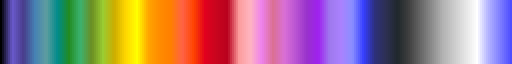

In [10]:
# define RAD_REF colorbar:
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
###################################################
#                                                 #
#     Define Ben's Base Reflectivity Colormap:    #
#   https://www.wxtools.org/reflectivity/bens-br  #
#                                                 #
###################################################

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
# dictionary from RGB color to the corresponding DBZ value
colors_dict = {
    (0, 0, 0): -10,
    (106, 90, 205): 10,
    (72, 61, 139): 12,
    (70, 130, 180): 14,
    (95, 158, 160): 16,
    (0, 139, 139): 18,
    (34, 139, 34): 20,
    (60, 179, 113): 22,
    (107, 142, 35): 24,
    (154, 205, 50): 26,
    (205, 173, 0): 28,
    (255, 215, 0): 30,
    (255, 255, 0): 32,
    (255, 165, 0): 34,
    (255, 140, 0): 36,
    (255, 127, 0): 38,
    (255, 99, 71): 40,
    (255, 69, 0): 42,
    (226, 1, 30): 44,
    (200, 6, 30): 46,
    (185, 1, 30): 48,
    (252, 156, 156): 50,
    (255, 182, 193): 52,
    (238, 130, 238): 54,
    (219, 112, 147): 56,
    (218, 112, 214): 58,
    (186, 85, 211): 60,
    (153, 50, 204): 62,
    (160, 32, 240): 64,
    (159, 121, 238): 66,
    (171, 130, 255): 68,
    (138, 143, 255): 70,
    (54, 62, 255): 72,
    (45, 48, 122): 74,
    (45, 48, 82): 76,
    (32, 40, 44): 78,
    (0, 0, 0): 80,  # Note: The dBZ of 80 uses the same color as -10 DBZ
    (64, 64, 64): 82,
    (102, 102, 102): 84,
    (140, 140, 140): 86,
    (179, 179, 179): 88,
    (204, 204, 204): 90,
    (230, 230, 230): 92,
    (255, 255, 255): 94,
    (179, 179, 255): 96,
    (128, 128, 255): 98,
    (77, 77, 255): 100
    #(240, 200, 240, 4): 100,  # alternative solid color upper bound, requires alpha
    #(250, 250, 250, 5): 100,  # alternative solid color upper bound, requires alpha
}


# Extracting RGB values
rgb_values = np.array(list(colors_dict.keys()))/255

# Extracting DBZ values
dbz_values = np.array(list(colors_dict.values()))

# make a discete, listed, colormap
rr_cmap_disc = ListedColormap(rgb_values,name="Ben's Base Reflectivity (Discrete)")

# make a continuous colormap from the discrete set of colors
rr_cmap_cont = LinearSegmentedColormap.from_list("Ben's Base Reflectivity (Continuous)",rgb_values)
rr_cmap_cont

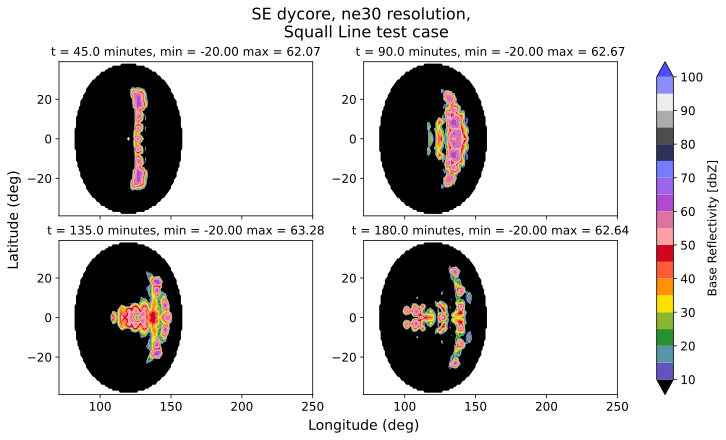

In [11]:
# Make the plot!
# fig, axes = plt.subplots(len(t_idxs),1, figsize=(6.5,10.0*len(t_idxs)/4.0), sharex=True, layout='constrained')
fig, axes = plt.subplots(2,2, figsize=(10.0,6.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

fix_minmax = True

# For the title
dycore_res = f'{model} {res}'

# Feel free to add additional fields
if field == 'T':
    title = 'Temperature perturbation'
    cb_label = '$T - T_0$ [K]'
    min_val = -2
    max_val = 5
elif field == 'U':
    title = 'Normalised zonal velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$ [m/s]'
    min_val = -1.5
    max_val = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v(t)$ [m/s]'
    min_val = -9
    max_val = 9
elif field == 'W':
    title = "Vertical velocity"
    cb_label = '$w(t)$ [m/s]'
    min_val = -14
    max_val = 14
elif field == "vor":
    title = "Relative vorticity"
    cb_label = '$\zeta(t)$ [1/s]'
    round_dig = 6
    min_val = -0.00014*small_earth_fact
    max_val = 0.00016*small_earth_fact
elif field == "div":
    title = "Fluid divergence"
    cb_label = '$\sigma(t)$ [1/s]'
    round_dig = 6
    min_val = -0.00003*small_earth_fact
    max_val = 0.00003*small_earth_fact
elif field == "Q":
    title = "Specific humidity"
    cb_label = 'mixing ratio'
    round_dig = 3
    min_val = 0
    max_val = 1
elif field == "PRECT":
    title = "Total precipitation rate"
    cb_label = '[mm/day]'
    round_dig = 0
    min_val = 0
    max_val = 0.01
elif field == "TMCLDLIQ":
    title = "Vertically integrated cloud liquid"
    cb_label = '$[kg/m^2]$'
    round_dig = 2
    min_val = 0
    max_val = 20
elif field == "TMRAINQM":
    title = "Column rain liquid"
    cb_label = '$[kg/m^2]$'
    min_val = 0
    max_val = 100
elif field == 'RAD_REF' or field == 'composite_RAD_REF' or 'base_reflectivity':
    title = "Radar Reflectivity"
    if field == 'composite_RAD_REF':
        title = 'Composite ' + title
    elif field == 'base_reflectivity':
        title = 'Base Reflectivity'
    cb_label = '[dbZ]'
    min_val = 10
    max_val = 100

# for the color map
valmin = np.nanmin(field_vals)
valmax = np.nanmax(field_vals)
if ((-1e-10 > valmin) and (1e-10 < valmax)):
    if fix_minmax:
        norm = MidpointNormalize(midpoint = 0, vmin = min_val, vmax = max_val)
    else:
        norm = MidpointNormalize(midpoint = 0, vmin = valmin, vmax = valmax)
    cmap_choice = 'RdBu_r'
elif (valmin < 1e-10):
    cmap_choice = "Blues"
    if (fix_minmax):
        norm = colors.Normalize(vmin=min_val, vmax=max_val)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)       
else:
    if (fix_minmax):
        norm = colors.Normalize(vmin=min_val, vmax=max_val)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)
    cmap_choice = 'RdYlBu_r'

if fix_minmax:
    levels = 17
    levels = np.mgrid[min_val:max_val:levels*1j]
else:
    levels = 15
    valmin = round(valmin, -int(floor(log10(abs(valmin)))))
    valmax = round(valmax, -int(floor(log10(abs(valmax)))))
    levels = np.mgrid[valmin:valmax:levels*1j]

if field == 'RAD_REF' or field == 'composite_RAD_REF' or field == 'base_reflectivity':
    norm = colors.Normalize(vmin=min_val, vmax=max_val)
    cmap_choice = rr_cmap_cont
    levels = 19
    if fix_minmax:
        levels = np.mgrid[min_val:max_val:levels*1j]
    else:
        valmin = round(valmin, -int(floor(log10(abs(valmin)))))
        valmax = round(valmax, -int(floor(log10(abs(valmax)))))
        levels = np.mgrid[valmin:valmax:levels*1j]

plts = []

for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm)
    plts.append(plot)
    # ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {time_stamps[t_idxs[ind]]*24*60} minutes, min = ' + '%.*f' % (round_dig, np.nanmin(field_vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(field_vals[ind])))

cb = plt.colorbar(plts[0], ax=axes, fraction=0.03)
# cb = fig.colorbar(plts[0], ax=axes, fraction=0.03)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle(f'{model} dycore, {res} resolution, \n Squall Line test case', size=title_size)

plt.show()

In [12]:
# measure how much asymmetry the model introduces
l2error = np.zeros(len(time_stamps))
south_inds = np.where(lats < 0)[0]
north_inds = np.where(lats > 0)[0][::-1]
for i in range(len(time_stamps)):
    if two_d:
        if field == 'composite_RAD_REF':
            diff = np.max(nc[field.split('_', 1)[1]][i, :, south_inds], axis=1) - \
            np.max(nc[field.split('_', 1)[1]][i, :, north_inds], axis=1)
        elif field == 'base_reflectivity':
            print('This plot has not been set up for base reflectivity')
            break
        else:
            diff = nc[field][i,south_inds] - nc[field][i,north_inds]
    else:
        diff = nc[field][i,:,south_inds] - nc[field][i,:,north_inds] # add or subtract depending on the field
    # not available for vor, div, W
    l2error[i] = np.linalg.norm(diff)/np.size(diff)

This plot has not been set up for base reflectivity


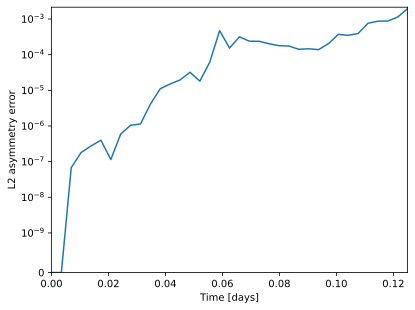

In [13]:
if field == 'base_reflectivity':
    print('This plot has not been set up for base reflectivity')
else:
    plt.plot(time_stamps, l2error)
    plt.xlabel('Time [days]')
    plt.ylabel('L2 asymmetry error')
    plt.ylim(0, 1.1*np.max(l2error))
    plt.xlim(0, time_stamps[-1])
    plt.yscale('symlog', linthresh=1e-9)
    plt.show()

# Base Reflectivity
The Base Reflectivity is the radar reflectivity from the lowest elevation radar scan. A radar scan released at a given elevation does not necessarily travel parallel to Earth's surface due to it's curvature and the change in the index of refraction with height. Therefore, in general the base reflectivity is a scan covering several altitudes, typically increasing with height at larger ranges. We will use the simple 4/3 Earth Radius Model (43ERM) to approximate the radar beam height. This approximation is good for standard atmospheric conditions in the first 10-20 km and for high elevation angles. A typical base reflectivity measurement uses the $0.5^\circ$ elevation and so the approximation may not be the most accurate. However, it is simple, analytic, and does not require an explicity computation of the local index of refraction. Other methods exist that use pressure, temperature, and vapor pressure to compute the index of refraction and calculate the actual curvature of the radar path through either an iteration of straight line paths or by solving an initial value problem along the range of the radar beam. See [[Zeng et al. 2014]](https://doi.org/10.1175/JTECH-D-13-00152.1) for more details on the various methods for computing the radar beam path.

In [13]:
# simulated radar parameters
h0 = 250.0 # m (a bit large but this is above the lowest interface level, there are no RAD_REF measurements below that level)
lat0 = 0.0
lon0 = center_lon
epsilon0 = 0.5 # deg (a typical elevation angle used for the base reflectivity)
max_range = 300.0e3 # m (as used by Zeng et. al 2014 Journal of Atm and Oceanic Tech)

# compute base reflectivity
br = base_reflectivity(nc, t_idxs, lat_inds, lon_inds,
                       h0, lat0, lon0, epsilon0, max_range,
                       R_earth, small_earth_fact, fullEarthRadar_smallEarthDistance=False)

h_max: 191.37 km
s_max: 158.86 km
Time Index 9
Time Index 18
Time Index 27
Time Index 36


In [14]:
# compute base reflectivity using reduced Earth radius for measuring distances
# but the normal Earth radius to compute the radar beam path (i.e. simulate 
# the radar beam footprint from the full size Earth)
br_FullEarth = base_reflectivity(nc, t_idxs, lat_inds, lon_inds,
                                 h0, lat0, lon0, epsilon0, max_range,
                                 R_earth, small_earth_fact,fullEarthRadar_smallEarthDistance=True)

h_max: 8.16 km
s_max: 299.76 km
Time Index 9
Time Index 18
Time Index 27
Time Index 36


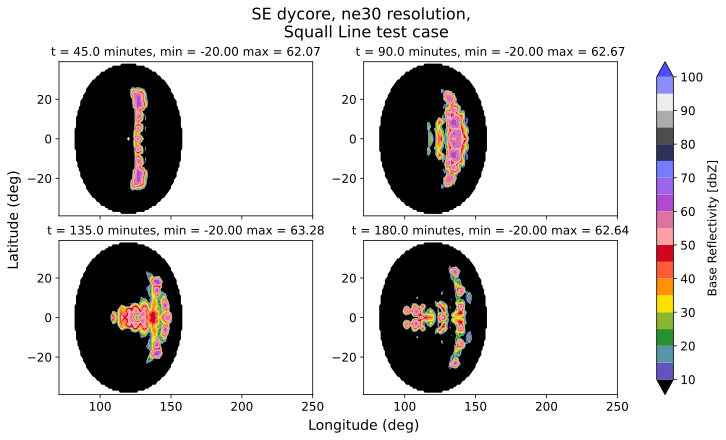

In [15]:
field = 'base_reflectivity'
field_vals = br
# Make the plot!
# fig, axes = plt.subplots(len(t_idxs),1, figsize=(6.5,10.0*len(t_idxs)/4.0), sharex=True, layout='constrained')
fig, axes = plt.subplots(2,2, figsize=(10.0,6.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

fix_minmax = True

# For the title
dycore_res = f'{model} {res}'

# Feel free to add additional fields
if field == 'T':
    title = 'Temperature perturbation'
    cb_label = '$T - T_0$ [K]'
    min_val = -2
    max_val = 5
elif field == 'U':
    title = 'Normalised zonal velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$ [m/s]'
    min_val = -1.5
    max_val = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v(t)$ [m/s]'
    min_val = -9
    max_val = 9
elif field == 'W':
    title = "Vertical velocity"
    cb_label = '$w(t)$ [m/s]'
    min_val = -14
    max_val = 14
elif field == "vor":
    title = "Relative vorticity"
    cb_label = '$\zeta(t)$ [1/s]'
    round_dig = 6
    min_val = -0.00014*small_earth_fact
    max_val = 0.00016*small_earth_fact
elif field == "div":
    title = "Fluid divergence"
    cb_label = '$\sigma(t)$ [1/s]'
    round_dig = 6
    min_val = -0.00003*small_earth_fact
    max_val = 0.00003*small_earth_fact
elif field == "Q":
    title = "Specific humidity"
    cb_label = 'mixing ratio'
    round_dig = 3
    min_val = 0
    max_val = 1
elif field == "PRECT":
    title = "Total precipitation rate"
    cb_label = '[mm/day]'
    round_dig = 0
    min_val = 0
    max_val = 0.01
elif field == "TMCLDLIQ":
    title = "Vertically integrated cloud liquid"
    cb_label = '$[kg/m^2]$'
    round_dig = 2
    min_val = 0
    max_val = 20
elif field == "TMRAINQM":
    title = "Column rain liquid"
    cb_label = '$[kg/m^2]$'
    min_val = 0
    max_val = 100
elif field == 'RAD_REF' or field == 'composite_RAD_REF' or 'base_reflectivity':
    title = "Radar Reflectivity"
    if field == 'composite_RAD_REF':
        title = 'Composite ' + title
    elif field =='base_reflectivity':
        title = 'Base Reflectivity'
    cb_label = '[dbZ]'
    min_val = 10
    max_val = 100

# for the color map
valmin = np.nanmin(field_vals)
valmax = np.nanmax(field_vals)
if ((-1e-10 > valmin) and (1e-10 < valmax)):
    if fix_minmax:
        norm = MidpointNormalize(midpoint = 0, vmin = min_val, vmax = max_val)
    else:
        norm = MidpointNormalize(midpoint = 0, vmin = valmin, vmax = valmax)
    cmap_choice = 'RdBu_r'
elif (valmin < 1e-10):
    cmap_choice = "Blues"
    if (fix_minmax):
        norm = colors.Normalize(vmin=min_val, vmax=max_val)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)       
else:
    if (fix_minmax):
        norm = colors.Normalize(vmin=min_val, vmax=max_val)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)
    cmap_choice = 'RdYlBu_r'

if fix_minmax:
    levels = 17
    levels = np.mgrid[min_val:max_val:levels*1j]
else:
    levels = 15
    valmin = round(valmin, -int(floor(log10(abs(valmin)))))
    valmax = round(valmax, -int(floor(log10(abs(valmax)))))
    levels = np.mgrid[valmin:valmax:levels*1j]

if field == 'RAD_REF' or field == 'composite_RAD_REF' or 'base_reflectivity':
    norm = colors.Normalize(vmin=min_val, vmax=max_val)
    cmap_choice = rr_cmap_cont
    levels = 19
    if fix_minmax:
        levels = np.mgrid[min_val:max_val:levels*1j]
    else:
        valmin = round(valmin, -int(floor(log10(abs(valmin)))))
        valmax = round(valmax, -int(floor(log10(abs(valmax)))))
        levels = np.mgrid[valmin:valmax:levels*1j]

plts = []

for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm)
    plts.append(plot)
    # ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {time_stamps[t_idxs[ind]]*24*60} minutes, min = ' + '%.*f' % (round_dig, np.nanmin(field_vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(field_vals[ind])))

cb = plt.colorbar(plts[0], ax=axes, fraction=0.03)
# cb = fig.colorbar(plts[0], ax=axes, fraction=0.03)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle(f'{model} dycore, {res} resolution, \n Squall Line test case', size=title_size)

plt.show()

In [40]:
# plot a longitude-altitude slice of RAD_REF with a simulated radar scan over plotted.
def plot_br_scan_slice(nc, t_idxs, lat_idxs, lon_idxs,
                       h0, lat0, lon0, epsilon0, max_range,
                       R_earth, small_Earth_factor, fullEarthRadar_smallEarthDistance=False):

    if fullEarthRadar_smallEarthDistance:
        R_earth_for_distances = R_earth/small_Earth_factor
        R_earth_for_beam      = R_earth
    else:
        R_earth_for_distances = R_earth/small_Earth_factor
        R_earth_for_beam      = R_earth/small_Earth_factor

    
    # compute
    def great_circle_distance(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = np.deg2rad(lat1), np.deg2rad(lon1), np.deg2rad(lat2), np.deg2rad(lon2)
        dlon = lon2 - lon1
        d = R_earth_for_distances * np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(dlon))
        return d
    
    def compute_s_from_latlon(lat, lon, lat0, lon0):
        s = great_circle_distance(lat0, lon0, lat, lon)
        return s
    
    def radar_path(h0, epsilon0, r):
        Reff = 4/3 * R_earth_for_beam
        epsilon0_rad = np.radians(epsilon0)
        h = np.sqrt((Reff + h0)**2 + r**2 + 2*(Reff+h0)*r*np.sin(epsilon0_rad)) - Reff
        s = Reff * np.arcsin(r*np.cos(epsilon0_rad) / (Reff + h))
        
        return h, s


    lats    = nc['lat'][:]
    try:
        lat0_idx = np.where(lats == lat0)[0][0]
    except:
        raise ValueError("lat0 must be exist within nc['lat']")
    # setup variables
    rad_ref  = nc['RAD_REF'][t_idxs, :, lat0_idx, lon_idxs]
    Z3       = nc['Z3'][t_idxs, :, lat0_idx, lon_idxs]
    lons     = nc['lon'][lon_idxs]
     
    
    h_max, s_max = radar_path(h0, epsilon0, max_range)
    print(f'h_max: {h_max/1.0e3:.2f} km')
    print(f's_max: {s_max/1.0e3:.2f} km')

    # compute h and s along path
    r = np.linspace(0, max_range)
    h = np.zeros_like(r)
    s = np.zeros_like(r)
    for i in range(0,len(r)):
        h[i], s[i] = radar_path(h0, epsilon0, r[i])
    # convert s in longitude so we can plot (altitude vs longitude at lat0)
    dlon = (s / R_earth_for_distances) * 180 / np.pi # the shift in longitude for a given s at the equator 

    lon_beam = lon0 + dlon

    fig, axes = plt.subplots(2,2, figsize=(10.0,6.0), sharex=True, layout='constrained')

    title_size=16
    label_size=14
    small_size=12
    round_dig = 2
    
    fix_minmax = True
    
    # For the title
    dycore_res = f'{model} {res}'
    title = 'Radar Reflectivity'
    cb_label = '[dbZ]'
    min_val = 10
    max_val = 100
    
    # for the color map
    valmin = np.nanmin(rad_ref)
    valmax = np.nanmax(rad_ref)
    norm = colors.Normalize(vmin=min_val, vmax=max_val)
    cmap_choice = rr_cmap_cont
    levels = 19
    if fix_minmax:
        levels = np.mgrid[min_val:max_val:levels*1j]
    else:
        valmin = round(valmin, -int(floor(log10(abs(valmin)))))
        valmax = round(valmax, -int(floor(log10(abs(valmax)))))
        levels = np.mgrid[valmin:valmax:levels*1j]
    
    plts = []
    # set bounds by ztop, and latlon slice or beam range (whichever is smaller)
    ztop_max = np.max(Z3)
    lon_max = min([np.max(lons),lon_beam[-1]+5.0])
    lon_min = max([np.min(lons),lon0-dlon[-1]-5.0])
    for ind, ax in enumerate(np.ravel(axes)):
        Z3_subset = Z3[ind, :, :]
        LON_subset = lons * np.ones_like(Z3_subset)
        if fix_minmax:
            plot = ax.contourf(LON_subset, Z3_subset, rad_ref[ind, :, :], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
            if ind == 0:
                beam_plot = ax.plot(lon_beam, h, '--', color = 'white',label = 'Base Radar Scan')
                ax.plot(lon0 - dlon, h, '--', color = 'white')
                ax.plot(lon0, h0, '.', color = 'white', markersize = 10) # the radar locaton!
                ax.legend()
            else:
                beam_plot = ax.plot(lon_beam, h, '--', color = 'white')
                ax.plot(lon0 - dlon, h, '--', color = 'white')
                ax.plot(lon0, h0, '.', color = 'white', markersize = 10)
        else:
            plot = ax.contourf(LON_subset, LAT_subset, rad_ref[ind, :, :], levels=levels, cmap=cmap_choice, norm=norm)
            if ind == 0:
                beam_plot = ax.plot(lon_beam, h, '--', color = 'white',label = 'Base Radar Scan')
                ax.plot(lon0 - dlon, h, '--', color = 'white')
                ax.plot(lon0, h0, '.', color = 'white', markersize = 10) # the radar locaton!                
                ax.legend()
            else:
                beam_plot = ax.plot(lon_beam, h, '--', color = 'white')
                ax.plot(lon0 - dlon, h, '--', color = 'white')
                ax.plot(lon0, h0, '.', color = 'white', markersize = 10) # the radar locaton!

        
        plts.append(plot)
        # ax.set_aspect('equal')
        
            
        ax.set_xlim([lon_min,lon_max])
        ax.set_ylim([0.0, ztop_max])
        ax.tick_params(axis='both', labelsize=small_size)
        ax.set_title(f't = {time_stamps[t_idxs[ind]]*24*60} minutes, min = ' + '%.*f' % (round_dig, np.nanmin(rad_ref[ind, :, :])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(rad_ref[ind, :, :])))
    
    cb = plt.colorbar(plts[0], ax=axes, fraction=0.03)
    # cb = fig.colorbar(plts[0], ax=axes, fraction=0.03)
    cb.set_label(label=title + " " + cb_label, size=small_size)
    cb.ax.tick_params(labelsize=small_size)
    
    fig.supylabel('Latitude (deg)', size=label_size)
    fig.supxlabel('Longitude (deg)', size=label_size)
    
    fig.suptitle(f'{dycore_res} lat = {lat0:.1f} deg Squall Line test case \n Simulated Base Radar Scan', size=title_size)
    
    plt.show()

    return

h_max: 191.37 km
s_max: 158.86 km


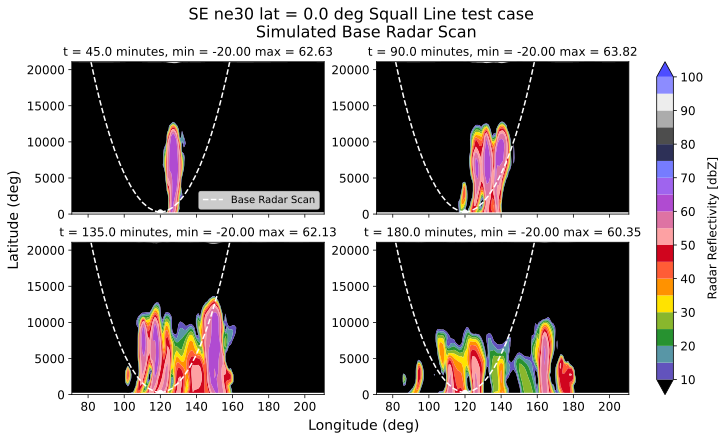

In [39]:
# plot a vertical longitude cross section centered at the simulated radar
# to visualize what parts of the squall line are scanned by the base
# reflectivity
plot_br_scan_slice(nc, t_idxs, lat_inds, lon_inds,
                       h0, lat0, lon0, epsilon0, max_range,
                       R_earth, small_earth_fact, fullEarthRadar_smallEarthDistance=False)